In [186]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.init as init
from math import log10
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image, ImageFilter
from os import listdir
from os.path import join
from tqdm import tqdm           #display loop evolution

In [187]:
#Data

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])

def load_img(filepath):
    img = Image.open(filepath).convert('RGB')
    return img

CROP_SIZE = 32

class DatasetFromFolder(Dataset):
    def __init__(self, image_dir, scale_factor, with_bicubic_upsampling = True):
        super(DatasetFromFolder, self).__init__()
        self.image_filenames = [join(image_dir, x) for x in listdir(image_dir) if is_image_file(x)]

        crop_size = CROP_SIZE - (CROP_SIZE % scale_factor) # Valid crop size
        
        if with_bicubic_upsampling:
            self.input_transform = transforms.Compose([transforms.CenterCrop(crop_size), # cropping the image
                                        transforms.Resize(crop_size//scale_factor),  # subsampling the image (half size)
                                        transforms.ToTensor()])
        else:
            self.input_transform = transforms.Compose([transforms.CenterCrop(crop_size), # cropping the image
                                        transforms.Resize(crop_size//scale_factor),  # subsampling the image (half size)
                                        transforms.ToTensor()])
                
        self.target_transform = transforms.Compose([transforms.CenterCrop(crop_size), # since it's the target, we keep its original quality
                                       transforms.ToTensor()])

    def __getitem__(self, index):
        input = load_img(self.image_filenames[index])
        target = input.copy()
        
        input = input.filter(ImageFilter.GaussianBlur(1)) 
        input = self.input_transform(input)
        target = self.target_transform(target)

        return input, target

    def __len__(self):
        return len(self.image_filenames)

In [188]:
#Model

###Classes of Generator and Discriminator

class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=16):
        super(Generator, self).__init__()
        self.initial = ConvBlock(in_channels, num_channels, kernel_size=9, stride=1, padding=4, use_bn=False, use_act=True)
        self.residuals = nn.Sequential(*[ResidualBlock(num_channels) for _ in range(num_blocks)])
        self.convblock = ConvBlock(num_channels, num_channels, kernel_size=3, stride=1, padding=1, use_bn=True, use_act=False)
        self.upsamples = nn.Sequential(UpSampleBlock(num_channels, 2), UpSampleBlock(num_channels, 2))          #To change to adapt to different scale_factors (here set up for scale_factor=4)
        self.final = nn.Conv2d(num_channels, in_channels, kernel_size=9, stride=1, padding=4)
    
    def forward(self, x):
        initial = self.initial(x)
        x = self.residuals(initial)
        x = initial + self.convblock(x)
        x = self.upsamples(x)
        x = self.final(x)
        return x
    
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 64, 128, 128, 256, 256, 512, 512]):
        super(Discriminator, self).__init__()
        blocks = []
        for idx, feature in enumerate(features):
            blocks.append(ConvBlock(in_channels, feature, kernel_size=3, stride=1+idx%2, padding=1, discriminator=True,
                                    use_act=True, use_bn=False if idx==0 else True))
            in_channels = feature
        
        self.blocks = nn.Sequential(*blocks)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((6, 6)),
            nn.Flatten(),
            nn.Linear(features[-1]*6*6, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1)
        )

    def forward(self, x):
        x = self.blocks(x)
        x = self.classifier(x)
        return x #torch.sigmoid(x)  ##sigmoid in paper! ...



####Classes of model's blocks

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, discriminator=False, use_act=True, use_bn=True, **kwargs):
        super(ConvBlock, self).__init__()
        self.use_act = use_act
        self.use_bn = use_bn
        self.cnn = nn.Conv2d(in_channels, out_channels, **kwargs, bias=not use_bn)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(0.2, inplace=True) if discriminator else nn.PReLU(num_parameters=out_channels)
    
    def forward(self, x):
        x = self.cnn(x)
        x = self.bn(x) if self.use_bn else x
        x = self.act(x) if self.use_act else x
        return x

class UpSampleBlock(nn.Module):
    def __init__(self, in_channels, scale_factor):
        super(UpSampleBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels*scale_factor**2, kernel_size=3, stride=1, padding=1)
        self.ps = nn.PixelShuffle(scale_factor)
        self.act = nn.PReLU(num_parameters=in_channels)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.ps(x)
        return self.act(x)
    
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block1 = ConvBlock(in_channels, in_channels, kernel_size=3, stride=1, padding=1, use_act=True, use_bn=True)
        self.block2 = ConvBlock(in_channels, in_channels, kernel_size=3, stride=1, padding=1, use_act=False, use_bn=True)

    def forward(self, x):
        x1 = self.block1(x)
        x2 = self.block2(x1)
        return x1 + x2

In [189]:
#VGG-Loss
from turtle import forward

from torchvision.models import vgg19  # VGG19 to match the paper

cuda = True
device = torch.device("cuda:0" if (torch.cuda.is_available() and cuda) else "cpu")

class VGGLoss(nn.Module):
    def __init__(self):
        super(VGGLoss, self).__init__()
        self.vgg = vgg19(weights='DEFAULT').features[:36].eval().to(device)   #36 to match phi5,4 as in the original paper 
        self.loss = nn.MSELoss()

        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, input, target):
        vgg_input_features = self.vgg(input)
        vgg_target_features = self.vgg(target)
        return self.loss(vgg_input_features, vgg_target_features)

In [190]:
#Main

# Parameters
BATCH_SIZE = 4
NUM_WORKERS = 0 # on Windows, set this variable to 0
LEARNING_RATE = 1e-4
scale_factor = 4
nb_epochs = 100
cuda = True
device = torch.device("cuda:0" if (torch.cuda.is_available() and cuda) else "cpu")
torch.manual_seed(0)
torch.cuda.manual_seed(0)


trainset = DatasetFromFolder("data/train", scale_factor=scale_factor)
testset = DatasetFromFolder("data/test", scale_factor=scale_factor)

trainloader = DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
testloader = DataLoader(dataset=testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

generator = Generator(in_channels=3).to(device)                 #Working on R,G,B channels
discriminator = Discriminator(in_channels=3).to(device)         #Working on R,G,B channels

optimizer_generator = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))

mse = nn.MSELoss()
bce = nn.BCEWithLogitsLoss()
vgg_loss = VGGLoss()


hist_loss_train = []
hist_loss_test = []
hist_psnr_train = []
hist_psnr_test = []
for epoch in range(nb_epochs):
    # Train
    avg_psnr = 0
    epoch_loss = 0
    for idx, (low_res, high_res) in enumerate(tqdm(trainloader)):
        high_res = high_res.to(device)
        low_res = low_res.to(device)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z))) (bce-logit loss)
        fake_image_generator = generator(low_res)
        output_real_discriminator = discriminator(high_res)
        output_fake_discriminator = discriminator(fake_image_generator.detach())

        discriminator_loss_real = bce(output_real_discriminator, torch.ones_like(output_real_discriminator) - 0.1*torch.rand_like(output_real_discriminator))
        discriminator_loss_fake = bce(output_fake_discriminator, torch.zeros_like(output_fake_discriminator))
        discriminator_loss = discriminator_loss_real + discriminator_loss_fake

        optimizer_discriminator.zero_grad()
        discriminator_loss.backward()
        optimizer_discriminator.step()


        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output_fake_discriminator = discriminator(fake_image_generator)

        adversarial_loss = 1e-3 * bce(output_fake_discriminator, torch.ones_like(output_fake_discriminator))     #in paper also explor l2_loss = mse(fake_image_generator, high_res)
        loss_for_vgg = 0.006 * vgg_loss(fake_image_generator, high_res)
        generator_loss = adversarial_loss + loss_for_vgg

        optimizer_generator.zero_grad()
        generator_loss.backward()
        optimizer_generator.step()

        ##### loss & psnr update
        epoch_loss += generator_loss.item()
        avg_psnr += 10 * log10(1 / generator_loss.item())

    ### loss & psnr train and test
    hist_loss_train.append(epoch_loss / len(trainloader))
    hist_psnr_train.append(avg_psnr / len(trainloader))

    avg_psnr = 0
    epoch_loss = 0
    with torch.no_grad():
        for batch in testloader:
            input, target = batch[0].to(device), batch[1].to(device)

            fake_image_generator = generator(input)
            output_real_discriminator = discriminator(target)
            output_fake_discriminator = discriminator(fake_image_generator.detach())

            discriminator_loss_real = bce(output_real_discriminator, torch.ones_like(output_real_discriminator) - 0.1*torch.rand_like(output_real_discriminator))
            discriminator_loss_fake = bce(output_fake_discriminator, torch.zeros_like(output_fake_discriminator))
            discriminator_loss = discriminator_loss_real + discriminator_loss_fake

            output_fake_discriminator = discriminator(fake_image_generator)

            adversarial_loss = 1e-3 * bce(output_fake_discriminator, torch.ones_like(output_fake_discriminator))     #in paper also explor l2_loss = mse(fake_image_generator, target)
            loss_for_vgg = 0.006 * vgg_loss(fake_image_generator, target)
            generator_loss = adversarial_loss + loss_for_vgg

            epoch_loss += generator_loss.item()
            avg_psnr += 10 * log10(1 / generator_loss.item())

    print(f"Average PSNR: {avg_psnr / len(testloader)} dB.")
    hist_loss_test.append(epoch_loss / len(testloader))
    hist_psnr_test.append(avg_psnr / len(testloader))

torch.save(generator, f"model_{epoch}.pth")


100%|██████████| 63/63 [01:39<00:00,  1.58s/it]


Average PSNR: 25.195149425921063 dB.


100%|██████████| 63/63 [01:40<00:00,  1.60s/it]


Average PSNR: 23.345314543705147 dB.


100%|██████████| 63/63 [01:36<00:00,  1.53s/it]


Average PSNR: 22.688737148440335 dB.


100%|██████████| 63/63 [01:28<00:00,  1.40s/it]


Average PSNR: 23.441764109480026 dB.


100%|██████████| 63/63 [01:34<00:00,  1.50s/it]


Average PSNR: 24.208679265804296 dB.


100%|██████████| 63/63 [01:32<00:00,  1.47s/it]


Average PSNR: 22.493097323921315 dB.


100%|██████████| 63/63 [01:44<00:00,  1.66s/it]


Average PSNR: 22.85824415245114 dB.


100%|██████████| 63/63 [01:19<00:00,  1.26s/it]


Average PSNR: 24.131873077942398 dB.


100%|██████████| 63/63 [01:19<00:00,  1.26s/it]


Average PSNR: 25.245795305229155 dB.


100%|██████████| 63/63 [01:15<00:00,  1.20s/it]


Average PSNR: 23.708176179810632 dB.


100%|██████████| 63/63 [01:17<00:00,  1.24s/it]


Average PSNR: 25.298393413308627 dB.


100%|██████████| 63/63 [01:19<00:00,  1.27s/it]


Average PSNR: 25.065878910146516 dB.


100%|██████████| 63/63 [01:26<00:00,  1.37s/it]


Average PSNR: 25.73445289195922 dB.


100%|██████████| 63/63 [01:18<00:00,  1.25s/it]


Average PSNR: 25.318166304461002 dB.


100%|██████████| 63/63 [01:43<00:00,  1.64s/it]


Average PSNR: 23.976184652458407 dB.


100%|██████████| 63/63 [01:53<00:00,  1.80s/it]


Average PSNR: 24.083481621042097 dB.


100%|██████████| 63/63 [01:49<00:00,  1.73s/it]


Average PSNR: 24.141213279757377 dB.


100%|██████████| 63/63 [01:42<00:00,  1.63s/it]


Average PSNR: 25.019672082587718 dB.


100%|██████████| 63/63 [02:07<00:00,  2.02s/it]


Average PSNR: 22.33631222624658 dB.


100%|██████████| 63/63 [01:33<00:00,  1.48s/it]


Average PSNR: 24.464841965265517 dB.


100%|██████████| 63/63 [01:20<00:00,  1.28s/it]


Average PSNR: 24.513635075289706 dB.


100%|██████████| 63/63 [01:28<00:00,  1.41s/it]


Average PSNR: 24.767647178787666 dB.


100%|██████████| 63/63 [01:19<00:00,  1.26s/it]


Average PSNR: 24.319339586728777 dB.


100%|██████████| 63/63 [01:20<00:00,  1.28s/it]


Average PSNR: 25.258485597568114 dB.


100%|██████████| 63/63 [01:27<00:00,  1.39s/it]


Average PSNR: 25.032236853274178 dB.


100%|██████████| 63/63 [01:35<00:00,  1.51s/it]


Average PSNR: 22.559787591039488 dB.


100%|██████████| 63/63 [01:33<00:00,  1.48s/it]


Average PSNR: 23.48897835704662 dB.


100%|██████████| 63/63 [01:28<00:00,  1.41s/it]


Average PSNR: 24.662750863411954 dB.


100%|██████████| 63/63 [01:33<00:00,  1.48s/it]


Average PSNR: 23.02178834390603 dB.


100%|██████████| 63/63 [01:56<00:00,  1.85s/it]


Average PSNR: 23.502058109714753 dB.


100%|██████████| 63/63 [01:35<00:00,  1.52s/it]


Average PSNR: 25.485692903530794 dB.


100%|██████████| 63/63 [01:36<00:00,  1.53s/it]


Average PSNR: 24.14006170869764 dB.


100%|██████████| 63/63 [01:53<00:00,  1.79s/it]


Average PSNR: 23.139368169006733 dB.


100%|██████████| 63/63 [01:14<00:00,  1.19s/it]


Average PSNR: 22.472561262150734 dB.


100%|██████████| 63/63 [01:13<00:00,  1.17s/it]


Average PSNR: 23.348265925391274 dB.


100%|██████████| 63/63 [01:11<00:00,  1.14s/it]


Average PSNR: 24.23405530643959 dB.


100%|██████████| 63/63 [01:13<00:00,  1.17s/it]


Average PSNR: 23.914410047626838 dB.


100%|██████████| 63/63 [01:14<00:00,  1.18s/it]


Average PSNR: 23.449368430402156 dB.


100%|██████████| 63/63 [01:38<00:00,  1.56s/it]


Average PSNR: 23.784315516949697 dB.


100%|██████████| 63/63 [01:28<00:00,  1.41s/it]


Average PSNR: 23.988872080318604 dB.


100%|██████████| 63/63 [01:19<00:00,  1.27s/it]


Average PSNR: 24.646179092629872 dB.


100%|██████████| 63/63 [01:17<00:00,  1.24s/it]


Average PSNR: 23.998879808679614 dB.


100%|██████████| 63/63 [01:22<00:00,  1.31s/it]


Average PSNR: 23.787157294804572 dB.


100%|██████████| 63/63 [01:19<00:00,  1.27s/it]


Average PSNR: 22.878057845399333 dB.


100%|██████████| 63/63 [01:19<00:00,  1.26s/it]


Average PSNR: 22.96687860929772 dB.


100%|██████████| 63/63 [01:21<00:00,  1.29s/it]


Average PSNR: 25.285059097833077 dB.


100%|██████████| 63/63 [01:20<00:00,  1.28s/it]


Average PSNR: 23.657679770796 dB.


100%|██████████| 63/63 [01:20<00:00,  1.27s/it]


Average PSNR: 23.087091140271035 dB.


100%|██████████| 63/63 [01:17<00:00,  1.22s/it]


Average PSNR: 22.65112359548852 dB.


100%|██████████| 63/63 [01:14<00:00,  1.19s/it]


Average PSNR: 23.70018017312776 dB.


100%|██████████| 63/63 [01:11<00:00,  1.13s/it]


Average PSNR: 25.504637428710947 dB.


100%|██████████| 63/63 [01:11<00:00,  1.13s/it]


Average PSNR: 22.27656394250777 dB.


100%|██████████| 63/63 [01:09<00:00,  1.10s/it]


Average PSNR: 24.076716578758603 dB.


100%|██████████| 63/63 [01:12<00:00,  1.15s/it]


Average PSNR: 22.580844026075226 dB.


100%|██████████| 63/63 [01:11<00:00,  1.13s/it]


Average PSNR: 24.86913585653804 dB.


100%|██████████| 63/63 [01:12<00:00,  1.15s/it]


Average PSNR: 24.26098636328181 dB.


100%|██████████| 63/63 [01:12<00:00,  1.15s/it]


Average PSNR: 25.354659021166825 dB.


100%|██████████| 63/63 [01:14<00:00,  1.19s/it]


Average PSNR: 25.037109627225053 dB.


100%|██████████| 63/63 [01:11<00:00,  1.13s/it]


Average PSNR: 24.34274421309253 dB.


100%|██████████| 63/63 [01:12<00:00,  1.16s/it]


Average PSNR: 23.80371167646943 dB.


100%|██████████| 63/63 [01:11<00:00,  1.14s/it]


Average PSNR: 23.25671030854485 dB.


100%|██████████| 63/63 [01:24<00:00,  1.34s/it]


Average PSNR: 25.460793264693482 dB.


100%|██████████| 63/63 [01:28<00:00,  1.40s/it]


Average PSNR: 23.881942294669933 dB.


100%|██████████| 63/63 [01:21<00:00,  1.29s/it]


Average PSNR: 23.41283248058394 dB.


100%|██████████| 63/63 [01:37<00:00,  1.55s/it]


Average PSNR: 24.051718597352014 dB.


100%|██████████| 63/63 [01:25<00:00,  1.36s/it]


Average PSNR: 23.429711774323145 dB.


100%|██████████| 63/63 [01:24<00:00,  1.34s/it]


Average PSNR: 23.820857889650277 dB.


100%|██████████| 63/63 [01:28<00:00,  1.41s/it]


Average PSNR: 25.038847971811116 dB.


100%|██████████| 63/63 [01:28<00:00,  1.40s/it]


Average PSNR: 24.739332474112764 dB.


100%|██████████| 63/63 [01:28<00:00,  1.41s/it]


Average PSNR: 24.28346678562878 dB.


100%|██████████| 63/63 [01:24<00:00,  1.35s/it]


Average PSNR: 22.996881996886348 dB.


100%|██████████| 63/63 [01:34<00:00,  1.50s/it]


Average PSNR: 26.248916656799153 dB.


100%|██████████| 63/63 [01:26<00:00,  1.37s/it]


Average PSNR: 25.391713939422228 dB.


100%|██████████| 63/63 [01:21<00:00,  1.29s/it]


Average PSNR: 24.19236271791896 dB.


100%|██████████| 63/63 [01:26<00:00,  1.38s/it]


Average PSNR: 23.42125839307493 dB.


100%|██████████| 63/63 [01:28<00:00,  1.41s/it]


Average PSNR: 25.397542234585575 dB.


100%|██████████| 63/63 [01:22<00:00,  1.30s/it]


Average PSNR: 24.77658804400406 dB.


100%|██████████| 63/63 [01:51<00:00,  1.77s/it]


Average PSNR: 24.878460773923482 dB.


100%|██████████| 63/63 [01:29<00:00,  1.41s/it]


Average PSNR: 24.495926119743636 dB.


100%|██████████| 63/63 [01:16<00:00,  1.21s/it]


Average PSNR: 25.59689758517756 dB.


100%|██████████| 63/63 [01:38<00:00,  1.56s/it]


Average PSNR: 24.99052317951286 dB.


100%|██████████| 63/63 [01:43<00:00,  1.65s/it]


Average PSNR: 24.444576624187583 dB.


100%|██████████| 63/63 [01:53<00:00,  1.81s/it]


Average PSNR: 25.49569214833467 dB.


100%|██████████| 63/63 [01:27<00:00,  1.40s/it]


Average PSNR: 25.04745331785463 dB.


100%|██████████| 63/63 [02:03<00:00,  1.97s/it]


Average PSNR: 25.853872741248896 dB.


100%|██████████| 63/63 [01:49<00:00,  1.74s/it]


Average PSNR: 25.589374142872128 dB.


100%|██████████| 63/63 [02:14<00:00,  2.13s/it]


Average PSNR: 24.57853793714025 dB.


100%|██████████| 63/63 [01:53<00:00,  1.79s/it]


Average PSNR: 25.68095992576281 dB.


100%|██████████| 63/63 [01:21<00:00,  1.29s/it]


Average PSNR: 24.113914675144358 dB.


100%|██████████| 63/63 [01:19<00:00,  1.27s/it]


Average PSNR: 25.172825727310265 dB.


100%|██████████| 63/63 [01:52<00:00,  1.79s/it]


Average PSNR: 24.682564644882593 dB.


100%|██████████| 63/63 [01:44<00:00,  1.65s/it]


Average PSNR: 25.368463209663712 dB.


100%|██████████| 63/63 [01:20<00:00,  1.27s/it]


Average PSNR: 24.27360658110971 dB.


100%|██████████| 63/63 [01:18<00:00,  1.25s/it]


Average PSNR: 24.111488715456968 dB.


100%|██████████| 63/63 [01:19<00:00,  1.25s/it]


Average PSNR: 25.559570669985018 dB.


100%|██████████| 63/63 [01:19<00:00,  1.27s/it]


Average PSNR: 24.383183360183743 dB.


100%|██████████| 63/63 [01:21<00:00,  1.30s/it]


Average PSNR: 25.43551225338081 dB.


100%|██████████| 63/63 [01:22<00:00,  1.30s/it]


Average PSNR: 23.25270903948662 dB.


100%|██████████| 63/63 [01:25<00:00,  1.35s/it]


Average PSNR: 24.177516070461863 dB.


100%|██████████| 63/63 [01:28<00:00,  1.40s/it]


Average PSNR: 25.260508542400757 dB.


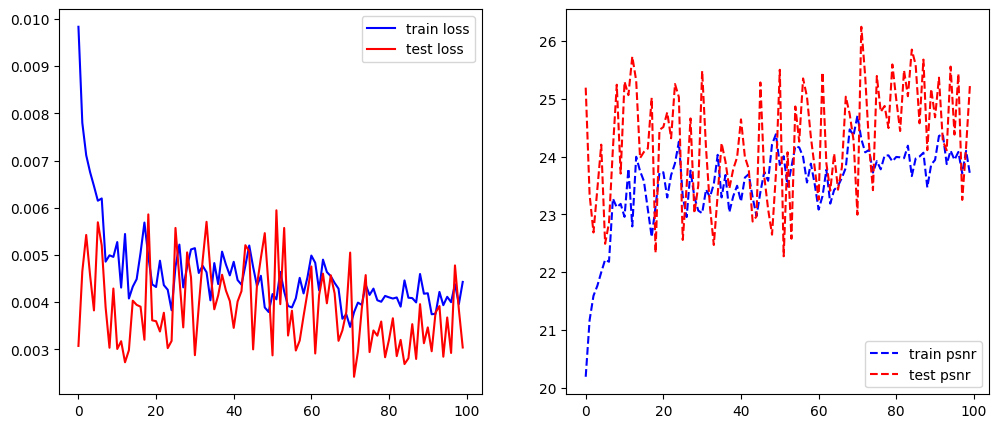

In [191]:
_, ax = plt.subplots(1,2)
ax[0].plot(hist_loss_train, label='train loss', c='b')
ax[0].plot(hist_loss_test, label='test loss', c='r')
ax[0].legend()
ax[1].plot(hist_psnr_train, label='train psnr', c='b', linestyle='--')
ax[1].plot(hist_psnr_test, label='test psnr', c='r', linestyle='--')
ax[1].legend()
_.set_size_inches(12,5)

/Users/adriensade/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:7: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  import sys


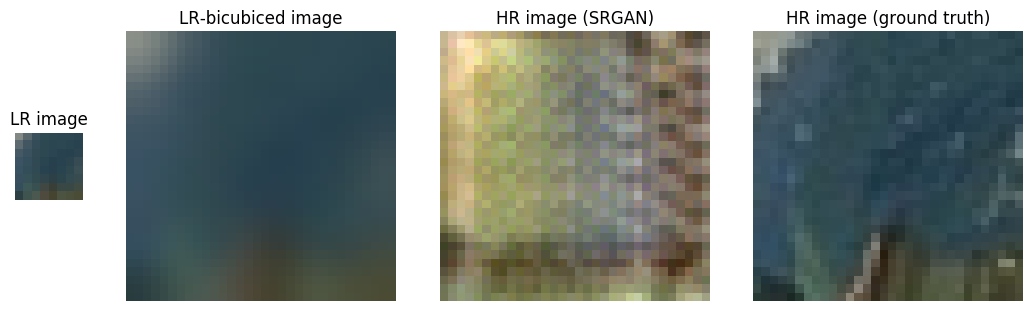

In [210]:
k = np.random.randint(0,13)
for idx, (test_features, test_labels) in enumerate(testloader):
    if idx != k: continue;

    crop_size = CROP_SIZE - (CROP_SIZE % scale_factor) # Valid crop size
    crop = transforms.CenterCrop(crop_size)
    upsample = transforms.Resize(crop_size, interpolation=Image.BICUBIC)

    i = np.random.randint(0,3)

    LR_original = test_features[i]
    LR = upsample(test_features[i])     #Low Resolution (bicubiced) image
    GT = test_labels[i]      #Ground Truth
    HR = generator(test_features.to(device))[i].cpu().detach().numpy().clip(0,1)       #High Resolution SRGAN


    _, ax = plt.subplots(1,4, gridspec_kw={'width_ratios': [1, scale_factor, scale_factor, scale_factor]})
    ax[0].imshow(LR_original.T)
    ax[1].imshow(LR.T)
    ax[2].imshow(HR.T)   
    ax[3].imshow(GT.T)
    ax[0].title.set_text('LR image')
    ax[1].title.set_text('LR-bicubiced image')
    ax[2].title.set_text('HR image (SRGAN)')
    ax[3].title.set_text('HR image (ground truth)')

    _.set_size_inches(13,13)
    for i in range(4): ax[i].set_axis_off()
    plt.show()
    #print(f"Label: {label}")